# Diffusion Model Tutorial Session
Welcome to the diffusion model tutorial session! <br>
---
Today's contents:
* Part 1: How are the basic diffusion models implemented?
* Part 2: How can we use the diffusion models?

# Part 1: How are the basic diffusion models implemented?

In [28]:
import torch
def check_gpu():
    if torch.cuda.is_available():
        print("GPU is available.")
    else:
        raise Exception("GPU not detected. Please make sure you have CUDA-enabled GPU.")

check_gpu() # Call the function to check GPU


!nvidia-smi

GPU is available.
Thu Mar  7 12:38:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:01:00.0 Off |                  N/A |
| 40%   44C    P2              111W / 350W|   5029MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-------

In [29]:
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

### Training & Evaluation Codes
#### Single epoch

In [30]:
class EMAMeter:
    def __init__(self, beta):
        self.beta = beta
        self.ema = None

    def update(self, value):
        if self.ema is None:
            self.ema = value
        else:
            self.ema = self.beta * self.ema + (1 - self.beta) * value

    def value(self):
        return self.ema

def train_epoch(model, dataloader, optimizer, lr_scheduler, device, smoothing = 0.95, condition = False):
    model.train()
    loss_ema = EMAMeter(smoothing)
    pbar = tqdm(dataloader)

    for x, c in pbar:
        optimizer.zero_grad()

        x, c = x.to(device), c.to(device)

        if not condition:
          loss = model.train_step(x)
        else:
          loss = model.train_step(x, c)

        loss.backward()
        optimizer.step()

        loss_ema.update(loss.item())
        pbar.set_description(f"loss: {loss_ema.value():.4f}")

    lr_scheduler.step()
    return loss_ema

def evaluate_epoch( # Plot generated images and animations
    model,
    device, w, save_dir,
    num_classes = 10,
    num_instances = 4,
    image_shape = (1, 28, 28),
    animate = True,
    condition = False
):
    num_sample = num_instances * num_classes

    model.eval()
    with torch.no_grad():

        if not condition:
            x_fake, x_fake_trajectory = model.sample(
                num_sample, image_shape, device
            )
        else:
            label_condition = torch.arange(num_classes).repeat(num_instances).to(device)
            x_fake, x_fake_trajectory = model.sample(
                num_sample, label_condition, image_shape,
                device, guidance_w=w
            )

    image = make_grid(1 - x_fake, nrow=10)
    plt.figure()
    plt.clf()
    #plt.imshow((image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))
    plt.imshow(image.permute(1, 2, 0).cpu().numpy() )
    plt.show()

    if animate:
        def _animate_denoise(i, axs, intermediate_results):
            print(f'gif animating frame {i} of {intermediate_results.shape[0]}', end='\r')
            plots = []
            for row in range(num_instances):
                for col in range(num_classes):
                    axs[row, col].clear()
                    axs[row, col].set_xticks([])
                    axs[row, col].set_yticks([])
                    plots.append(
                        axs[row, col].imshow(-intermediate_results[i,(row*num_classes)+col,0],
                        cmap='gray',
                        vmin=(-x_fake_trajectory[i]).min(),
                        vmax=(-x_fake_trajectory[i]).max())
                    )
            return plots

        # animate the denoising sampling process every 5 epochs
        x_fake_trajectory = np.array(x_fake_trajectory)
        fig, axs = plt.subplots(
            nrows=num_instances, ncols=num_classes,
            sharex=True,sharey=True,
            figsize=(8,3)
        )
        ani = FuncAnimation(fig,
            _animate_denoise, fargs=[axs, x_fake_trajectory],
            interval=200, blit=False, repeat=True,
            frames=x_fake_trajectory.shape[0]
        )
        ani
        result_name = f"{model.__class__.__name__}_guidance{w}.gif" if condition else f"{model.__class__.__name__}.gif"
        animation_path = os.path.join(save_dir, result_name)
        ani.save(animation_path, dpi=100, writer=PillowWriter(fps=5))
        print('saved animation at ', animation_path)

#### End-to-End Training Process

In [31]:
def train_mnist(model, device, num_classes = 10, num_epoch = 30, batch_size = 256, condition = False):
    model.to(device)

    transform = transforms.Compose([transforms.ToTensor()])
    dataset = MNIST("./data", train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    lr_scheduler = LinearLR(optimizer, start_factor=1.0, total_iters=num_epoch)

    for epoch in range(num_epoch):
        print(f'Epoch {epoch}')

        train_epoch(model, dataloader, optimizer, lr_scheduler, device, condition=condition)

        guidance_list = [0.0] if not condition else [0.0, 0.5, 1.0, 2.0, 4.0]
    for w in guidance_list:
        print("\t Guidance Weight: ", w)
        evaluate_epoch(
            model,
            device = device,
            w = w,
            save_dir= './',
            num_classes = num_classes,
            num_instances = 4,
            image_shape = (1, 28, 28),
            animate = True,
            condition = condition
        )

## Recap: Diffusion Models
* Forward process: Unstructure the input by injecting noise
* Reverse process: Generate an image from noise
* Forward kernel: Single step of injecting noise with Markovian process
    * Gaussian noise injected
    * $q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{\alpha_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I})$
    * $\beta_t$: variance (hyperparameter)
    * $\alpha_t = 1 - \beta_t$
* Reverse kernel: Single step of denoising with Markovian process
    * Approximated as Gaussian when noise is small
    * $p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_\theta(\mathbf{x}_t,t), \sigma_t^2\mathbf{I})$
    * $\mu_\theta(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(\mathbf{x}_t, t) \right)$
    * $\sigma_t$ is also hyperparameter
        * Usually, $\sigma_t = \sqrt{\beta_t}$

## Hyperparameter Setup
### Variance Scheduling
We will only use linear scheduling in this session. You can try other scheduling policies. (e.g., cosine scheduling)

Linear schedule:
$\beta_t = (\beta_T - \beta_1)\frac{t}{T} + \beta_1$

Let $\alpha_t := 1- \beta_t$ and $\bar{\alpha}_t := \prod_{s=1}^t \alpha_s$

In [32]:
def ddpm_linear_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1

    return beta_t

## Forward Process
Try both iterative and direct calculating versions. <br>

Iterative: $\mathbf{x}_t = \sqrt{\alpha_t} \mathbf{x}_{t-1} + \sqrt{\beta_t} \mathbf{\epsilon}$ <br>
Direct: $\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \mathbf{\epsilon}$

In [33]:
def forward_noise(x_0, t, beta_t, forward_type):
    if forward_type == "iterate":
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        x_t = x_0
        for i in range(t):
            x_t = torch.sqrt(1 - beta_t)[i+1] * x_t + torch.sqrt(beta_t)[i+1] * torch.randn_like(x_0)
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
    elif forward_type == "direct":
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        alpha_bar = torch.cumsum(torch.log(1 - beta_t), dim=0)[t].exp()
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * torch.randn_like(x_0)
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
    else:
        raise Exception("Invalid forward_type")

    return x_t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


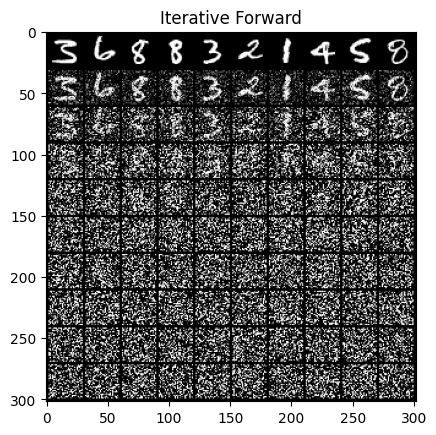

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


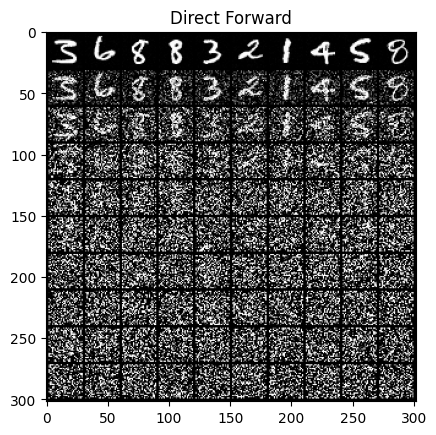

In [34]:
n_T = 1000
batch_size=10

transform = transforms.Compose([transforms.ToTensor()])
dataset = MNIST("./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)
sample_batch = next(iter(dataloader))[0][:10]
beta_t = ddpm_linear_schedules(1e-4, 0.02, n_T)

forward_list = []
forward_list2 = []

x = sample_batch
for t in range(0, n_T, 100):
    x = forward_noise(sample_batch, t, beta_t, "iterate")
    forward_list.append(x.detach().cpu())

for t in range(0, n_T, 100):
    x = forward_noise(sample_batch, t, beta_t, "direct")
    forward_list2.append(x.detach().cpu())

plt.figure()
plt.imshow(make_grid(torch.cat(forward_list), nrow=10).permute(1, 2, 0), cmap='gray')
plt.title("Iterative Forward")
plt.show()
plt.close()

plt.figure()
plt.imshow(make_grid(torch.cat(forward_list2), nrow=10).permute(1, 2, 0), cmap='gray')
plt.title("Direct Forward")
plt.show()
plt.close()

# DDPM
## U-Net Structure

In [35]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ):
        super().__init__()
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class SimpleUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256):
        super(SimpleUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.time_embedding_1 = EmbedFC(1, 2*n_feat)
        self.time_embedding_2 = EmbedFC(1, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        up1 = self.up0(hiddenvec)

        time_embed = self.time_embedding_1(t).view(-1, self.n_feat * 2, 1, 1)

        up2 = self.up1(up1 + time_embed, down2)

        time_embed = self.time_embedding_2(t).view(-1, self.n_feat, 1, 1)

        up3 = self.up2(up2 + time_embed, down1)

        out = self.out(torch.cat((up3, x), 1))
        return out

## DDPM Training Algorithm

**Repeat**

1. $\mathbf{x}_0 \sim q(\mathbf{x}_0)$

2. $t \sim \text{Uniform}(\{1,\cdots,T\})$

3. $\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$

4. Take a gradient descent step on $\nabla_\theta \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1- \bar{\alpha}_t}\mathbf{\epsilon}, t) \Vert $

**until** converged

---
## DDPM Inference (Data Sampling) Algorithm

1. $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
2. **for** $t = T, \cdots, 1$ **do**
 3. $z \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$  if $t > 1$, else $\mathbf{z} = \mathbf{0}$
 4. $\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_{\theta}(\mathbf{x}_t, t) \right) + \sqrt{\beta_t} \mathbf{z} $
5. **end for**
6. **return** $\mathbf{x}_0$

In [36]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, timesteps):
        super(DDPM, self).__init__()
        self.nn_model = nn_model

        beta_t = ddpm_linear_schedules(betas[0], betas[1], timesteps)
        self.register_buffer("beta_t", beta_t)

        self.T = timesteps
        self.loss = nn.MSELoss()

    def _forward_diffusion(self, t, x, noise):
        alpha_bar = torch.cumsum( torch.log(1-self.beta_t), dim=0 ).exp()
        return alpha_bar[t, None, None, None].sqrt() * x + (1-alpha_bar)[t, None, None, None].sqrt() * noise

    def _reverse_diffusion(self, t, x, epsilon, noise):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################

        beta = self.beta_t[t]
        alpha = 1 - beta
        alpha_bar = torch.cumsum( torch.log(1-self.beta_t), dim=0 ).exp()[t]
        x_tm1 = 1/(alpha.sqrt()) * (x - epsilon * beta / (1-alpha_bar).sqrt()) + beta.sqrt() * noise

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return x_tm1

    def train_step(self, x):
        batch_size = x.shape[0]

        self.nn_model = self.nn_model.to(x.device)
        t = torch.randint(1, self.T+1, (batch_size,)).to(x.device)

        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################

        noise = torch.randn_like(x)

        x_t = self._forward_diffusion(t, x, noise)

        estimated_noise = self.nn_model(x_t, t / self.T)

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

        return self.loss(noise, estimated_noise)

    def sample(self, num_sample, size, device):

        self.nn_model = self.nn_model.to(device)
        x = torch.randn(num_sample, *size).to(device)

        x_trajectory = []

        for i in range(self.T, 0, -1):
            t = torch.tensor([i / self.T]).repeat(num_sample).to(device)
            noise = torch.randn(num_sample, *size).to(device) if i > 1 else 0

            epsilon = self.nn_model(x, t)

            x = self._reverse_diffusion(i, x, epsilon, noise)

            if i%20==0 or i==self.T or i<8:
                x_trajectory.append(x.detach().cpu().numpy())

        return x, x_trajectory

Epoch 0


  0%|          | 0/235 [00:00<?, ?it/s]

loss: 0.0505: 100%|██████████| 235/235 [00:26<00:00,  8.82it/s]


Epoch 1


loss: 0.0405: 100%|██████████| 235/235 [00:27<00:00,  8.65it/s]


Epoch 2


loss: 0.0367: 100%|██████████| 235/235 [00:27<00:00,  8.62it/s]


Epoch 3


loss: 0.0333: 100%|██████████| 235/235 [00:27<00:00,  8.69it/s]


Epoch 4


loss: 0.0325: 100%|██████████| 235/235 [00:27<00:00,  8.58it/s]


Epoch 5


loss: 0.0314: 100%|██████████| 235/235 [00:27<00:00,  8.59it/s]


Epoch 6


loss: 0.0304: 100%|██████████| 235/235 [00:27<00:00,  8.55it/s]


Epoch 7


loss: 0.0297: 100%|██████████| 235/235 [00:27<00:00,  8.62it/s]


Epoch 8


loss: 0.0280: 100%|██████████| 235/235 [00:27<00:00,  8.67it/s]


Epoch 9


loss: 0.0287: 100%|██████████| 235/235 [00:27<00:00,  8.67it/s]


Epoch 10


loss: 0.0277: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s]


Epoch 11


loss: 0.0274: 100%|██████████| 235/235 [00:27<00:00,  8.55it/s]


Epoch 12


loss: 0.0269: 100%|██████████| 235/235 [00:27<00:00,  8.60it/s]


Epoch 13


loss: 0.0272: 100%|██████████| 235/235 [00:26<00:00,  8.72it/s]


Epoch 14


loss: 0.0276: 100%|██████████| 235/235 [00:27<00:00,  8.67it/s]


Epoch 15


loss: 0.0271: 100%|██████████| 235/235 [00:27<00:00,  8.69it/s]


Epoch 16


loss: 0.0260: 100%|██████████| 235/235 [00:26<00:00,  8.75it/s]


Epoch 17


loss: 0.0252: 100%|██████████| 235/235 [00:26<00:00,  8.72it/s]


Epoch 18


loss: 0.0258: 100%|██████████| 235/235 [00:27<00:00,  8.54it/s]


Epoch 19


loss: 0.0262: 100%|██████████| 235/235 [00:27<00:00,  8.58it/s]


Epoch 20


loss: 0.0250: 100%|██████████| 235/235 [00:27<00:00,  8.69it/s]


Epoch 21


loss: 0.0257: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s]


Epoch 22


loss: 0.0249: 100%|██████████| 235/235 [00:27<00:00,  8.67it/s]


Epoch 23


loss: 0.0250: 100%|██████████| 235/235 [00:27<00:00,  8.50it/s]


Epoch 24


loss: 0.0250: 100%|██████████| 235/235 [00:27<00:00,  8.57it/s]


Epoch 25


loss: 0.0246: 100%|██████████| 235/235 [00:26<00:00,  8.72it/s]


Epoch 26


loss: 0.0247: 100%|██████████| 235/235 [00:27<00:00,  8.70it/s]


Epoch 27


loss: 0.0249: 100%|██████████| 235/235 [00:27<00:00,  8.57it/s]


Epoch 28


loss: 0.0249: 100%|██████████| 235/235 [00:27<00:00,  8.58it/s]


Epoch 29


loss: 0.0248: 100%|██████████| 235/235 [00:27<00:00,  8.67it/s]


	 Guidance Weight:  0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


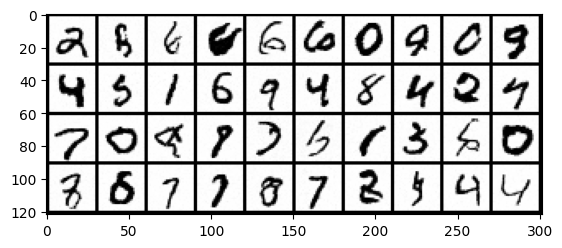

saved animation at  ./DDPM.gif


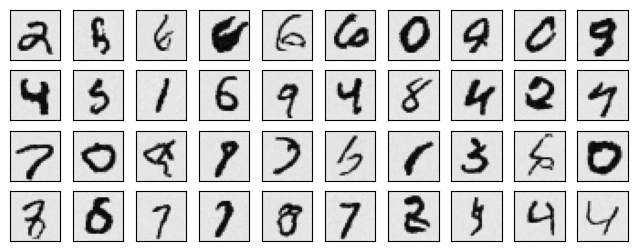

In [37]:
device = "cuda"

model = DDPM(
    nn_model=SimpleUnet(
        in_channels=1, n_feat=128
    ),
    betas=(1e-4, 0.02),
    timesteps = 400,
)

train_mnist(model = model, device = device, num_epoch=30, num_classes=10, condition = False)
torch.save(model.nn_model.state_dict(), "ddpm_mnist.pth")

# DDIM
## DDIM Training
`nn_model` of DDPM and DDIM has same input/output behavior and learning objective. We do not explicitly train the DDIM, but we reuse the model from the DDPM.

## DDIM Inference (Data Sampling) Algorithm

1. $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
2. **for** $t = T, \cdots, 1$ **do**
3. $z \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$  if $t > 1$, else $\mathbf{z} = \mathbf{0}$
4. $\hat{\mathbf{x}}_0 = \frac{\mathbf{x}_t - \sqrt{1-\bar{\alpha}_t} \epsilon_\theta(\mathbf{x}_t, t)}{\sqrt{\bar{\alpha}_t}}$
5. $\mathbf{x}_{t-1} = \sqrt{\bar{\alpha}_{t-1}}\hat{\mathbf{x}}_0 + \sqrt{1- \bar{\alpha}_{t-1} - \sigma_t^2} \epsilon_\theta(\mathbf{x}_t, t) + \sigma_t \mathbf{z} $
6. **end for**
7. **return** $\mathbf{x}_0$

We set $\sigma_t=0$ for DDIM.

In [38]:
class DDIM(DDPM):
    def __init__(self, nn_model, betas, timesteps, sigma = 0.0):
        super(DDIM, self).__init__(nn_model, betas, timesteps)
        self.sigma = float(sigma) if type(sigma) is int else sigma

    def _reverse_diffusion(self, t, x, epsilon, noise):
        sigma = self.sigma if type(self.sigma) is float else self.sigma[t]
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################

        alpha_bar = torch.cumsum( torch.log(1-self.beta_t), dim=0 ).exp()
        x0_t = (x - epsilon * (1 - alpha_bar[t]).sqrt()) / alpha_bar[t].sqrt()
        if t == 0:
            return x0_t
        x_tm1 = alpha_bar[t-1].sqrt() * x0_t + (1 - alpha_bar[t-1] - sigma**2).sqrt() * epsilon + sigma * noise

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return x_tm1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


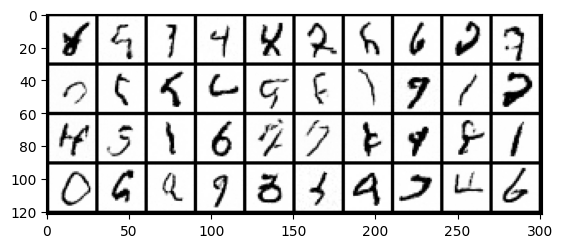

saved animation at  ./DDIM.gif


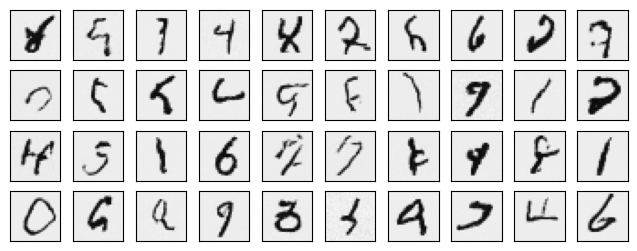

In [39]:
device = "cuda"
num_classes = 10

nn_model = SimpleUnet(
    in_channels=1, n_feat=128
)
nn_model.load_state_dict(torch.load("ddpm_mnist.pth"))

model = DDIM(
    nn_model=nn_model,
    betas=(1e-4, 0.02),
    timesteps = 400,
    sigma = 0
)
    
evaluate_epoch(
    model,
    device = device,
    w = 0.0,
    save_dir= './',
    num_classes = num_classes,
    num_instances = 4,
    image_shape = (1, 28, 28),
    animate=True,
    condition = False
)

# CFG (Classifier-Free Guidance)
## Recap
* Generating data $\mathbf{x}$ given condition $y$
* __Mix__ scores of conditional diffusion model and unconditional diffusion model
    * $\nabla_\mathbf{x} \log p_w(\mathbf{x}|y) = (1+w)\nabla_\mathbf{x} \log p(\mathbf{x}|y) - w\nabla_\mathbf{x} \log p(\mathbf{x})$
## Conditional U-Net Structure

In [40]:
class ConditionUnet(SimpleUnet):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ConditionUnet, self).__init__(in_channels, n_feat=n_feat)

        self.n_classes = n_classes

        self.condition_embedding_1 = EmbedFC(n_classes, 2*n_feat)
        self.condition_embedding_2 = EmbedFC(n_classes, 1*n_feat)

    def forward(self, x, c, t, condition_mask):
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)

        condition_mask = condition_mask[:, None].repeat(1,self.n_classes)
        c = c * (1-condition_mask)

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        up1 = self.up0(hiddenvec)

        condition_embed = self.condition_embedding_1(c).view(-1, self.n_feat * 2, 1, 1)
        time_embed = self.time_embedding_1(t).view(-1, self.n_feat * 2, 1, 1)

        up2 = self.up1(condition_embed*up1+ time_embed, down2)

        condition_embed = self.condition_embedding_2(c).view(-1, self.n_feat, 1, 1)
        time_embed = self.time_embedding_2(t).view(-1, self.n_feat, 1, 1)

        up3 = self.up2(condition_embed*up2+ time_embed, down1)

        out = self.out(torch.cat((up3, x), 1))
        return out

### Training CFG

**Require:** $p_{uncond}$: probability of unconditional training

**Repeat**

1. $(\mathbf{x}, \mathbf{c}) \sim p(\mathbf{x},\mathbf{c})$

2. $c ← ∅$ with probability $p_{uncond}$

2. $t \sim \text{Uniform}(\{1,\cdots,T\})$

3. $\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$

4. Take a gradient descent step on $\nabla_\theta \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_t}\mathbf{x} + \sqrt{1- \bar{\alpha}_t}\mathbf{\epsilon}, t, \mathbf{c}) \Vert $

**until** converged

---
## Conditional Sampling with CFG

**Require:** $w>0$: guidance strength, $\mathbf{c}$:  conditioning information

1. $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
2. **for** $t = T, \cdots, 1$ **do**
 3. $\tilde{\epsilon}_t = (1+w) \epsilon_{\theta}(\mathbf{x}_t, t, \mathbf{c}) - w \epsilon_{\theta}(\mathbf{x}_t, t, \emptyset)$
 3. $z \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$  if $t > 1$, else $\mathbf{z} = \mathbf{0}$
 4. $\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \tilde{\epsilon}_t \right) + \sqrt{\beta_t} \mathbf{z} $
5. **end for**
6. **return** $\mathbf{x}_0$

---

In [41]:
class CFG(DDPM):
    def __init__(self, nn_model, betas, timesteps, prob_unconditional=0.1):
        super(CFG, self).__init__(nn_model, betas, timesteps)

        self.prob_unconditional = prob_unconditional

    def _classifier_free_guidance(self, w, conditioned_epsilon, unconditioned_epsilon):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################

        epsilon = (1+w)*conditioned_epsilon - w*unconditioned_epsilon
        
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

        return epsilon

    def train_step(self, x, c):
        batch_size = x.shape[0]

        t = torch.randint(1, self.T+1, (batch_size,)).to(x.device)
        noise = torch.randn_like(x)

        x_t = self._forward_diffusion(t, x, noise)

        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################

        condition_dropout = torch.bernoulli(torch.ones_like(c) * self.prob_unconditional).to(x.device)
        estimated_noise = self.nn_model(x_t, c, t / self.T, condition_dropout)

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

        return self.loss(noise, estimated_noise)

    def sample(self, num_sample, condition, size, device, guidance_w = 0.0):

        x = torch.randn(num_sample, *size).to(device)

        conditioning_mask = torch.zeros_like(condition).to(device)
        unconditioning_mask = torch.ones_like(condition).to(device)

        x_trajectory = []

        for i in range(self.T, 0, -1):
            t = torch.tensor([i / self.T]).repeat(num_sample).to(device)

            noise = torch.randn(num_sample, *size).to(device) if i > 1 else 0

            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################

            conditioned_epsilon = self.nn_model(x, condition, t, conditioning_mask)
            unconditioned_epsilon = self.nn_model(x, condition, t, unconditioning_mask)

            epsilon = self._classifier_free_guidance(guidance_w, conditioned_epsilon, unconditioned_epsilon)

            x = self._reverse_diffusion(i, x, epsilon, noise)

            ##############################################################################
            #                          END OF YOUR CODE                                  #
            ##############################################################################

            if i%20==0 or i==self.T or i<8:
                x_trajectory.append(x.detach().cpu().numpy())

        return x, x_trajectory

Epoch 0


loss: 0.0480: 100%|██████████| 235/235 [00:27<00:00,  8.69it/s]


Epoch 1


loss: 0.0373: 100%|██████████| 235/235 [00:27<00:00,  8.56it/s]


Epoch 2


loss: 0.0326: 100%|██████████| 235/235 [00:27<00:00,  8.59it/s]


Epoch 3


loss: 0.0325: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s]


Epoch 4


loss: 0.0295: 100%|██████████| 235/235 [00:27<00:00,  8.56it/s]


Epoch 5


loss: 0.0297: 100%|██████████| 235/235 [00:27<00:00,  8.61it/s]


Epoch 6


loss: 0.0279: 100%|██████████| 235/235 [00:27<00:00,  8.70it/s]


Epoch 7


loss: 0.0271: 100%|██████████| 235/235 [00:27<00:00,  8.64it/s]


Epoch 8


loss: 0.0285: 100%|██████████| 235/235 [00:27<00:00,  8.70it/s]


Epoch 9


loss: 0.0269: 100%|██████████| 235/235 [00:27<00:00,  8.70it/s]


Epoch 10


loss: 0.0261: 100%|██████████| 235/235 [00:27<00:00,  8.69it/s]


Epoch 11


loss: 0.0260: 100%|██████████| 235/235 [00:27<00:00,  8.70it/s]


Epoch 12


loss: 0.0260: 100%|██████████| 235/235 [00:27<00:00,  8.68it/s]


Epoch 13


loss: 0.0247: 100%|██████████| 235/235 [00:27<00:00,  8.70it/s]


Epoch 14


loss: 0.0246: 100%|██████████| 235/235 [00:27<00:00,  8.56it/s]


Epoch 15


loss: 0.0241: 100%|██████████| 235/235 [00:27<00:00,  8.53it/s]


Epoch 16


loss: 0.0252: 100%|██████████| 235/235 [00:27<00:00,  8.60it/s]


Epoch 17


loss: 0.0252: 100%|██████████| 235/235 [00:27<00:00,  8.67it/s]


Epoch 18


loss: 0.0246: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s]


Epoch 19


loss: 0.0241: 100%|██████████| 235/235 [00:27<00:00,  8.61it/s]


Epoch 20


loss: 0.0244: 100%|██████████| 235/235 [00:27<00:00,  8.50it/s]


Epoch 21


loss: 0.0242: 100%|██████████| 235/235 [00:27<00:00,  8.62it/s]


Epoch 22


loss: 0.0239: 100%|██████████| 235/235 [00:27<00:00,  8.69it/s]


Epoch 23


loss: 0.0239: 100%|██████████| 235/235 [00:27<00:00,  8.70it/s]


Epoch 24


loss: 0.0238: 100%|██████████| 235/235 [00:27<00:00,  8.69it/s]


Epoch 25


loss: 0.0240: 100%|██████████| 235/235 [00:27<00:00,  8.59it/s]


Epoch 26


loss: 0.0231: 100%|██████████| 235/235 [00:27<00:00,  8.58it/s]


Epoch 27


loss: 0.0237: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s]


Epoch 28


loss: 0.0233: 100%|██████████| 235/235 [00:27<00:00,  8.69it/s]


Epoch 29


loss: 0.0235: 100%|██████████| 235/235 [00:27<00:00,  8.68it/s]


	 Guidance Weight:  0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


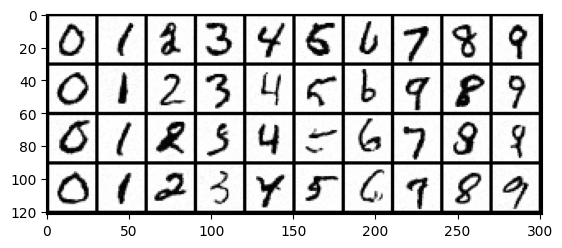

saved animation at  ./CFG_guidance0.0.gif
	 Guidance Weight:  0.5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


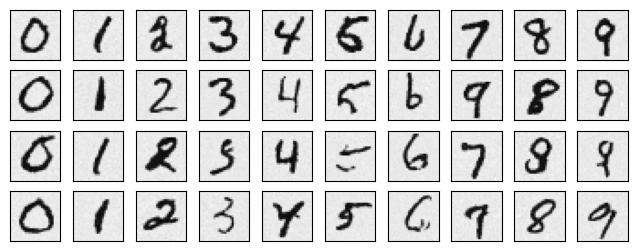

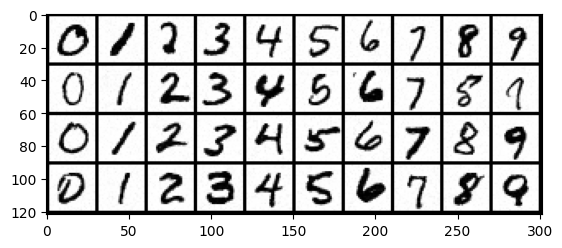

saved animation at  ./CFG_guidance0.5.gif
	 Guidance Weight:  1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


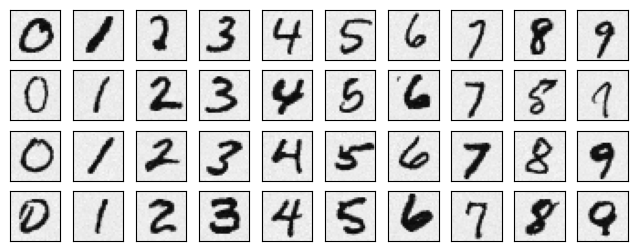

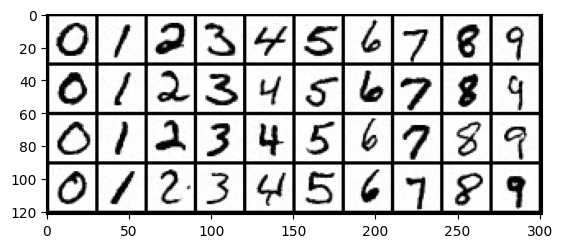

saved animation at  ./CFG_guidance1.0.gif
	 Guidance Weight:  2.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


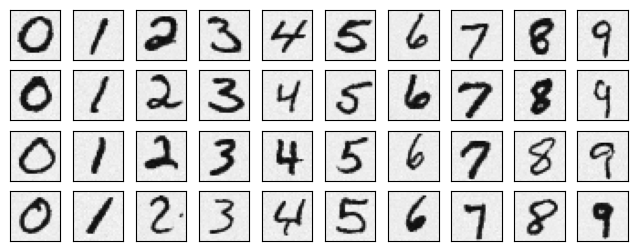

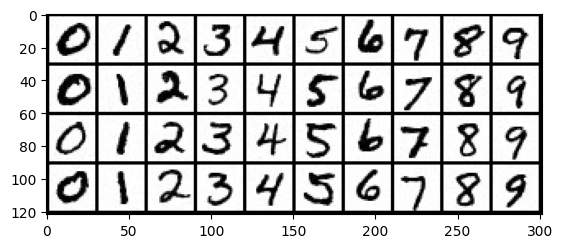

saved animation at  ./CFG_guidance2.0.gif
	 Guidance Weight:  4.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


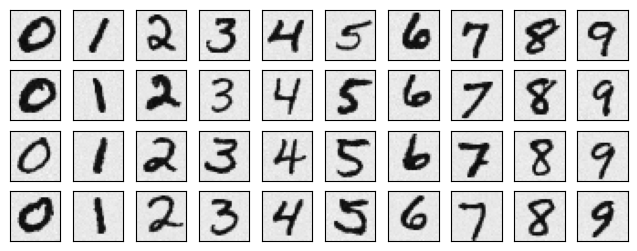

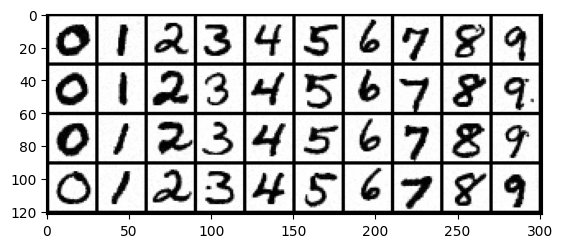

saved animation at  ./CFG_guidance4.0.gif


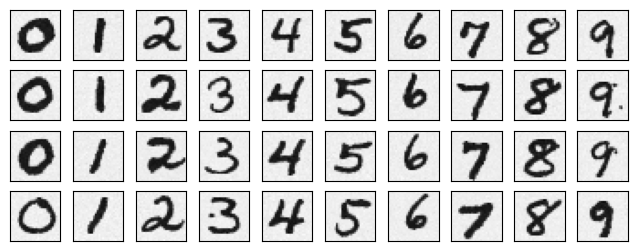

In [42]:
num_classes=10
device = "cuda"

model = CFG(
    nn_model=ConditionUnet(
        in_channels=1, n_feat=128, n_classes=num_classes
    ),
    betas=(1e-4, 0.02),
    timesteps = 400,
    prob_unconditional=0.1,
)

train_mnist(model = model, device = device, num_epoch=30, num_classes=num_classes, condition = True)
torch.save(model.state_dict(), "cfg_mnist.pth")